# Pricing Options (Black-Scholes)
* The purpose of this notebook is to demonstrate the fitting of a Gaussian Process Regression model (GP) to option price data. 
* In this notebook, European option prices are generated from the Black-Scholes model.  
* The notebook begins by building a GP call model, then a GP put model, and finally a portfolio holding which is short a put and long two calls. 

Note that the training sample size is set to 5 in order to illustrate the uncertainty bands. Seting the training sample size to a larger value, e.g. 50, will yield a much more accurate model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from BlackScholes import bsformula
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF

%matplotlib inline

## Black-Scholes model parameters

In [2]:
r = 0.0002  # risk-free rate
S= 100      # Underlying spot
KC = 130    # Call strike
KP = 70     # Put strike
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity

Define functions to create the Black-Scholes option prices, which we will use to train our Gaussian processes

In [3]:
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

# GP Call pricer
* Generate the training and testing data, where the input is the gridded underlying and the output are the call prices. 
* Note that the inputs are scaled to the unit domain to aid interpretation and comparison of the hyper-parameters across different experiments.
* A very small number of training points is used in order to emphasise the resulting uncertainties on the plots below.

In [8]:
lb = 0.001           # lower bound on domain
ub = 300             # upper bound on domain
training_number = 5  # Number of training samples
testing_number = 100 # Number of testing samples

np.random.seed(0)

train_x_1 = np.array(np.linspace(0, 1, training_number), dtype='float32').reshape(training_number, 1)
train_y_1 = [call(S) for S in train_x_1]
    
test_x_1 = np.array(np.linspace(0, 1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_1 = [call(S) for S in test_x_1]

Create a Gaussian process regression estimator with an RBF kernel, and fit it to the training data

In [9]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_1, train_y_1)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

Now we can get the predicted call values for the test data

In [10]:
y_pred_1, sigma_1 = gp.predict(test_x_1, return_std=True)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Comparing the GP predictions to the BS model

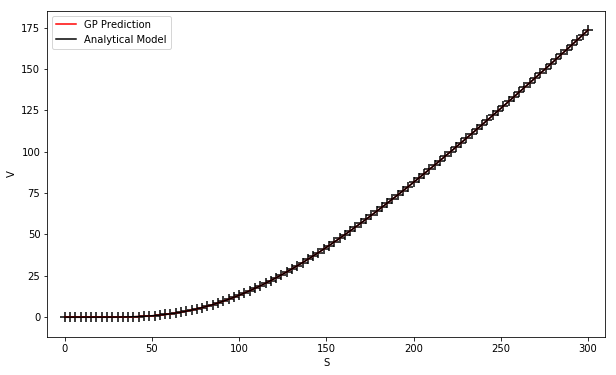

In [11]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([lb-10, ub+10])
plt.xlabel('S')
plt.ylabel('V');

# GP Put pricer

* Now we repeat the process to create a GP modelling the value of a put. 
* First, create the training and testing data with the Black-Scholes prices

In [12]:
train_x_2 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
train_y_2 = [put(S) for S in train_x_2]
    
test_x_2 = np.array(np.linspace(0,1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_2 = [put(S) for S in test_x_2]

Fit the GP to the training data

In [13]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_2, train_y_2)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

And get the predicted values for the test points

In [14]:
y_pred_2, sigma_2 = gp.predict(test_x_2, return_std=True)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Comparing the GP predictions to the BS model. Note the shape of the variance bands.

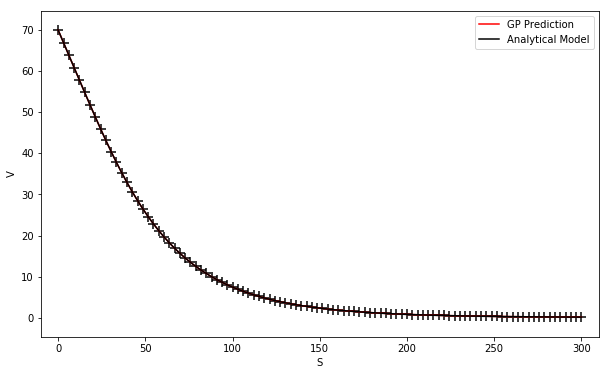

In [15]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_2, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y_2, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_2.flatten(), train_y_2, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_2.T-2*sigma_2).flatten(), (y_pred_2.T+2*sigma_2).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('S')
plt.ylabel('V');
plt.xlim([lb-10, ub+10]);

# Portfolio value

* The predicted call and put values can be combined to estimate the value of a portfolio as a function of the underlying.
* Here we long 2 calls and short a put:

In [16]:
# The Gaussian process' predictions
y_pred = 2 * y_pred_1 - y_pred_2
# Black-Scholes prices
test_y = 2 * np.array(test_y_1) - np.array(test_y_2)

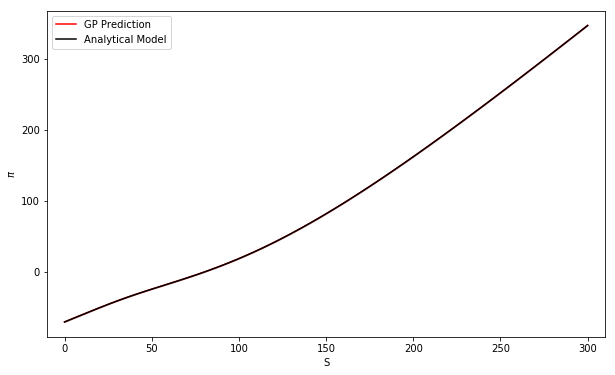

In [17]:
sigma = np.sqrt(sigma_1*sigma_1 + sigma_2*sigma_2)

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y.flatten(), color = 'black', label = 'Analytical Model')
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred.T-2*sigma).flatten(), (y_pred.T+2*sigma).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([lb-10, ub+10])
plt.xlabel('S')
plt.ylabel('$\pi$');